# Logistic Fittings

In [1]:
import numpy as np
import scipy.integrate as integrate
import random
import scipy.stats as stats
import numpy as np

import math
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Notation we use below.
arctan = np.arctan
cos = np.cos
det = np.linalg.det
exp = np.exp
inner = np.inner
log = np.log
matmul = np.matmul
norm = np.linalg.norm
odeint = integrate.odeint
pi = np.pi
quad = integrate.quad
randbinom = np.random.binomial
randexp = np.random.exponential
randnorm = np.random.normal
randperm = np.random.permutation
randuni = np.random.uniform
sin = np.sin
sqrt = np.sqrt

# Accessing Data

In [2]:
covid_vc = pd.read_csv('covid_variants_cases.csv') # 22a-c
covid_vc[:]


,Unnamed: 0,Unnamed: 0.1,week,total_sequences,deltas,omicrons,ba45,perc_deltas,perc_omicrons,perc_ba45,numDelta,numOmicron,numBA45,biweeklyDates,biweeklyCases,logistic_perc_deltas,logistic_perc_omicron,logistic_perc_ba45,date_time
0,0,0,2020-12-21,36771,11,0,0,0.000299,0.000000,0.000000,18.135297,0.000000,0.000000,Dec 21 2021,60623,-8.114270,-inf,-inf,2020-12-21
1,1,1,2021-01-11,35804,4,0,0,0.000112,0.000000,0.000000,4.172048,0.000000,0.000000,Jan 11 2021,37344,-9.099409,-inf,-inf,2021-01-11
2,2,2,2021-01-25,31768,1,0,0,0.000031,0.000000,0.000000,0.786357,0.000000,0.000000,Jan 25 2021,24981,-10.366183,-inf,-inf,2021-01-25
3,3,3,2021-02-08,34820,1,0,0,0.000029,0.000000,0.000000,0.767088,0.000000,0.000000,Feb 8 2021,26710,-10.457918,-inf,-inf,2021-02-08
4,4,4,2021-02-22,37323,2,0,0,0.000054,0.000000,0.000000,2.066715,0.000000,0.000000,Feb 22 2021,38568,-9.834164,-inf,-inf,2021-02-22
5,5,5,2021-03-08,48910,5,0,0,0.000102,0.000000,0.000000,7.936312,0.000000,0.000000,Mar 8 2021,77633,-9.188197,-inf,-inf,2021-03-08
6,6,6,2021-03-22,66582,23,0,0,0.000345,0.000000,0.000000,85.241837,0.000000,0.000000,Mar 22 2021,246764,-7.970350,-inf,-inf,2021-03-22
7,7,7,2021-04-05,77663,97,0,0,0.001249,0.000000,0.000000,869.539060,0.000000,0.000000,Apr 5 2021,696196,-6.684173,-inf,-inf,2021-04-05
8,8,8,2021-04-19,66041,467,0,0,0.007071,0.000000,0.000000,5381.775291,0.000000,0.000000,Apr 19 2021,761066,-4.944605,-inf,-inf,2021-04-19
9,9,9,2021-05-03,49602,837,0,0,0.016874,0.000000,0.000000,4314.156042,0.000000,0.000000,May 3 2021,255664,-4.064944,-inf,-inf,2021-05-03


In [3]:
# Change dates to datetime objects.
from datetime import datetime

ds = []

for d in range(len(covid_vc["week"])):
    # print(datetime.strptime(covid_vc["week"][d], "%Y-%m-%d"))
    ds.append(datetime.strptime(covid_vc["week"][d], "%Y-%m-%d"))
ds
covid_vc["date_time"] = ds

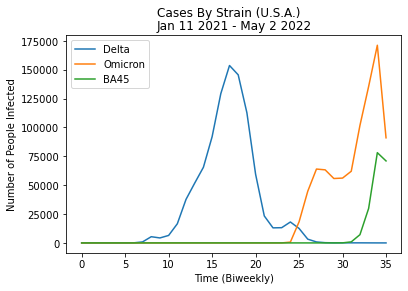

In [4]:
fig, ax = plt.subplots()
ax.plot(covid_vc["numDelta"], label='Delta')
ax.plot(covid_vc["numOmicron"], label='Omicron')
ax.plot(covid_vc["numBA45"], label='BA45')
legend = ax.legend(loc='upper left')

plt.title('Jan 11 2021 - May 2 2022')
plt.suptitle("Cases By Strain (U.S.A.)")
plt.xlabel('Time (Biweekly)')
plt.ylabel('Number of People Infected')

fig.savefig(r'/Users/JennyH/Documents/math690/figures/num_cases_usa.pdf', bbox_inches="tight")

Text(0, 0.5, 'Proportion of Population Infected')

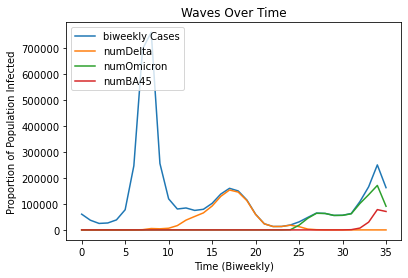

In [5]:
fig, ax = plt.subplots()
ax.plot(covid_vc["biweeklyCases"], label='biweekly Cases')
ax.plot(covid_vc["numDelta"], label='numDelta')
ax.plot(covid_vc["numOmicron"], label='numOmicron')
ax.plot(covid_vc["numBA45"], label='numBA45')
legend = ax.legend(loc='upper left')
plt.title('Waves Over Time')
plt.xlabel('Time (Biweekly)')
plt.ylabel('Proportion of Population Infected')

In [6]:
# SIR Ordinary Differential Equation
def V(x,t,beta,gamma):
    return [-beta*x[0]*x[1], beta*x[0]*x[1]-gamma*x[1], gamma*x[1]] # [s(t), i(t), r(t)]

In [7]:
# Fitting a range of different beta values. Play around with this!
beta_grid = np.linspace(start=.2, stop=1, num=20)
print(beta_grid)

[0.2        0.24210526 0.28421053 0.32631579 0.36842105 0.41052632
 0.45263158 0.49473684 0.53684211 0.57894737 0.62105263 0.66315789
 0.70526316 0.74736842 0.78947368 0.83157895 0.87368421 0.91578947
 0.95789474 1.        ]


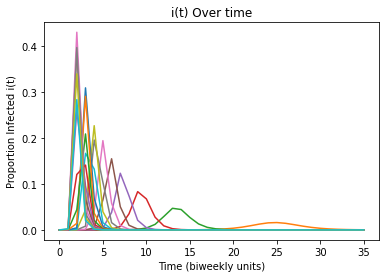

In [8]:
# Population size
N = 33000000

# fix gamma (5 day recovery)
gamma = 0.2

for beta in beta_grid: 
    
    # Initial condition; i_0 is the initial number of infected people
    i_0 = 1/N
    x = [1-i_0, i_0, 0]

    # Time
    days = 35*14
    steps = 36
    T = np.linspace(0,days,steps)

    # Integrate (aka solve) the ODE; phi is the solution phi=[s(t), i(t), r(t)]
    phi = odeint(V, x, T, args=(beta,gamma)) 

    # s compartment
    s = phi[:,0]
    # i compartment
    i = phi[:,1]
    # r compartment
    r = phi[:,2]
    
    
    # Plots of the solved differential equations
    plt.plot(T/14,i,label="i")
    plt.xlabel('Time (biweekly units)')
    plt.ylabel('Proportion Infected i(t)')
    plt.title('i(t) Over time')

### Logistic Growth Model
#### DOES THE PROPORTION OF A MORE VIRULENT STRAIN FIT A LOGISTIC GROWTH CURVE?

In [10]:
def L(x,t,beta,gamma):
    '''
    logistic growth curve differential equation.
    '''
    return [-beta*x[0]*x[1], x[1]*(1-x[1])*beta*1] # [ignore, i_2_prop]

In [11]:
# Play around with this grid of values.
diff_beta_grid = np.linspace(start=.1, stop=.2, num=10)
diff_beta_grid

array([0.1       , 0.11111111, 0.12222222, 0.13333333, 0.14444444,
       0.15555556, 0.16666667, 0.17777778, 0.18888889, 0.2       ])

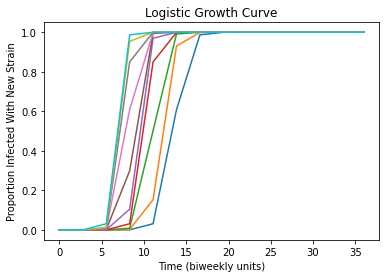

In [12]:
# Population size of USA
N = 329000000

for diff_beta in diff_beta_grid: 
    
    # proportions of i_1 and i_2
    prop_i_2 = 1/N # initial proportion of variant 2: i_2/(i_2+i_1) (find what epsilon*N)
    x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

    
    # Time units
    days = 14*36 # two weeks * 36 
    steps = 14 # every 2 weeks
    T = np.linspace(0,days,steps)

    # Integrate (aka solve) the ODE; the logistic_vector is the solution.
    logistic_vector = odeint(L, x, T, args=(diff_beta, gamma)) 

    i_logistic_curve = logistic_vector[:,1]

    # plot
    plt.plot(T/14,i_logistic_curve,label="Logistic Growth")
    plt.xlabel('Time (biweekly units)')
    plt.ylabel('Proportion Infected With New Strain')
    plt.title('Logistic Growth Curve')

## Code to solve the logistic equation given two data points.

In [13]:
def solve_logistic(y0, y1, delta_t):
    '''
    param:
    y0 - initial proportion infectious
    y1 - final proportion infectious
    delta_t - change in time (days)
    return: lambda = beta_2 - beta_1
    '''
    b = 1/y0 - 1
    diff_b = -1/delta_t * log((1/b)*(1/y1 - 1))
    
    return diff_b

In [14]:
# Beta to delta
# These two data points give the start to end of the logistic growth curve.

# (date1, percentdelta) = (May 3, 2021, 0.016874)
# (date2, percentdelta) = (Jul 26 2021, 0.899738)

print(solve_logistic(0.016874, 0.899738, 84)) # 0.0745
diff_betadelta = solve_logistic(0.016874, 0.899738, 84)

# Beta to delta 2
# These two data points give the start to end of the logistic growth curve.

# (date1, percentdelta) = (May 3, 2021, 0.016874)
# (date2, percentdelta) = (June 14, 2021, 0.446455)

print(solve_logistic(0.016874, 0.446455, 42)) # 0.0916
diff_betadelta_halfway = solve_logistic(0.016874, 0.446455, 42)

### --- ### --- ###

# Delta to omicron BA1/2/3
# These two data points give the start to end of the logistic growth curve.

# (date1, percentOmicron) = (Nov 29 2021, 0.037709327)
# (date2, percentOmicron) = (Jan 10 2022, 0.986774)

print(solve_logistic(0.037709327, 0.986774, 42)) # 0.1798
diff_omicronba123 = solve_logistic(0.037709327, 0.986774, 42)

# Delta to omicron BA1/2/3
# These two data points give the start to end of the logistic growth curve.

# (date1, percentOmicron) = (Nov 29 2021, 0.037709327)
# (date2, percentOmicron) = (Dec 13 2021, 0.591637)

print(solve_logistic(0.037709327, 0.591637, 14)) # 0.258
diff_omicronba123_halfway = solve_logistic(0.037709327, 0.591637, 14)

### --- ### --- ###

# Omicron BA1/2/3 to BA4/5
# These two data points give the start to end of the logistic growth curve.

# (date1, percentBA4/5) = (Mar 21 2022, 0.065300)
# (date2, percentBA4/5) = (May 2 2022, 0.436607)
# (date2updated, percentBA4/5) = (June 13 2022, 0.830986)

print(solve_logistic(0.065300, 0.830986, 84)) # 0.0572 (0.0506)
diff_ba123_ba45 = solve_logistic(0.065300, 0.830986, 84)


0.0745152400630254
0.09166568754617174
0.1798015605426319
0.25786756299515484
0.05064124978236794


Text(0, 0.5, 'Prop of Cases')

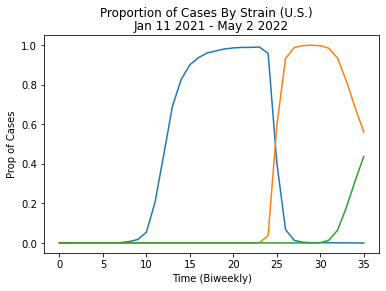

In [15]:
# Data From True Delta Props.
fig, ax = plt.subplots()
ax.plot(covid_vc["perc_deltas"], label='Prop of Cases Omicron')
ax.plot(covid_vc["perc_omicrons"], label='Prop of Cases Omicron')
ax.plot(covid_vc["perc_ba45"], label='Prop of Cases Omicron')

plt.title('Jan 11 2021 - May 2 2022')
plt.suptitle("Proportion of Cases By Strain (U.S.)")
plt.xlabel('Time (Biweekly)')
plt.ylabel('Prop of Cases')

# fig.savefig(r'/Users/JennyH/Documents/math690/figures/proportion_strain_USA.pdf', bbox_inches="tight")

Text(0.5, 0.98, 'Proportion of Cases By Strain (Jan 11 2021 - May 2 2022)')

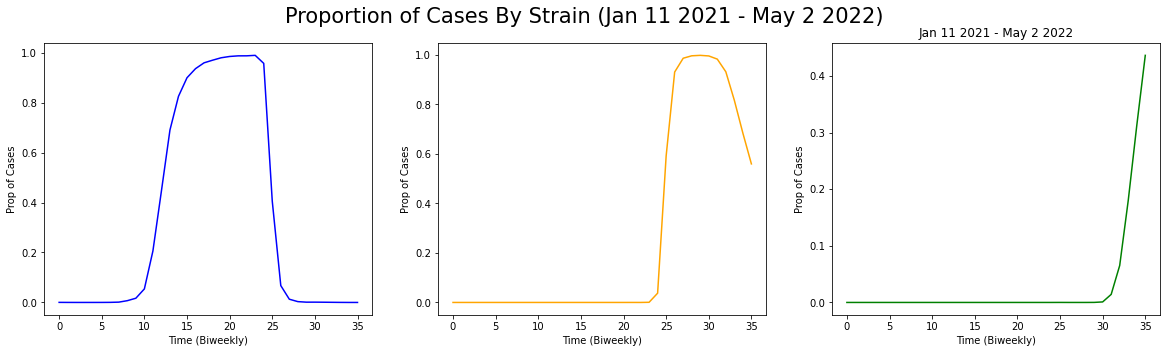

In [16]:
# Data from the 3 waves.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
fig.suptitle('Variant Competition')
plt.title('Jan 11 2021 - May 2 2022')

ax1.plot(covid_vc["perc_deltas"], label='Prop of Cases Omicron', color = 'blue')
ax1.set_xlabel('Time (Biweekly)')
ax1.set_ylabel('Prop of Cases') 

ax2.plot(covid_vc["perc_omicrons"], label='Prop of Cases Omicron', color = 'orange')
ax2.set_xlabel('Time (Biweekly)')
ax2.set_ylabel('Prop of Cases') 

ax3.plot(covid_vc["perc_ba45"], label='Prop of Cases Omicron', color = 'green')
ax3.set_xlabel('Time (Biweekly)')
ax3.set_ylabel('Prop of Cases') 

fig.suptitle("Proportion of Cases By Strain (Jan 11 2021 - May 2 2022)", size=21)
# fig.subtitle('Jan 11 2021 - May 2 2022')

### Updating Data for ba4/5 (update: last day, June 13, 2022)

In [17]:
june_data = pd.Series([0.6452, 0.763, 0.8310])

In [18]:
new_ba_4_5 = covid_vc["perc_ba45"].append(june_data, ignore_index=True)
# new_ba_4_5

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000048
26    0.000000
27    0.000000
28    0.000000
29    0.000086
30    0.000912
31    0.014231
32    0.065300
33    0.180049
34    0.312308
35    0.436607
36    0.645200
37    0.763000
38    0.831000
dtype: float64

## Below, the code numerically solves the logistic curve functions using the difference in betas found above.

In [20]:
# proportions of beta strain to delta strain.
prop_i_2 = 0.0168 # initial proportion of variant 2: i_2/(i_2+i_1)
x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

# Time units
days = 35*14 # two weeks * 36 data points
steps = 36 # number of time points to output.
T = np.linspace(0,days,steps)

# Integrate (aka solve) the ODE; the logistic_vector is the solution.
logistic_vector1 = odeint(L, x, T, args=(diff_betadelta, gamma)) 

betadelta = logistic_vector1[:,1]

In [21]:
# proportions of delta to omicron1/2/3 strain
prop_i_2 = 0.037709327 # initial proportion of variant 2: i_2/(i_2+i_1)
x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

# Time units
days = 35*14 # two weeks * 36 data points
steps = 36 # number of time points to output.
T = np.linspace(0,days,steps)

# Integrate (aka solve) the ODE; the logistic_vector is the solution.
logistic_vector2 = odeint(L, x, T, args=(diff_omicronba123, gamma))


delta_omicron12 = logistic_vector2[:,1]

In [22]:
# proportions of omicron1/2/3 to BA4/5
prop_i_2 = 0.065300 # initial proportion of variant 2: i_2/(i_2+i_1) (find what epsilon*N)
x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

# Time units
days = 35*14 # two weeks * 36 data points
steps = 36 # number of time points to output.
T = np.linspace(0,days,steps)

# Integrate (aka solve) the ODE; the logistic_vector is the solution.
logistic_vector3 = odeint(L, x, T, args=(diff_ba123_ba45, gamma))


ba123_ba45 = logistic_vector3[:,1]

In [24]:
# For creating aligned plots: Align the start times of observed waves with the logistic growth curve.

# beta to delta
starting_frame = [0]*9 # start from May 3rd, which is the 9th datapoint in covid_vc
betadelta = starting_frame + list(betadelta)

# delta to omicron
starting_frame = [0]*24
delta_omicron12 = starting_frame + list(delta_omicron12)

# omicron to ba4/5
starting_frame = [0]*32
ba123_ba45 = starting_frame + list(ba123_ba45)

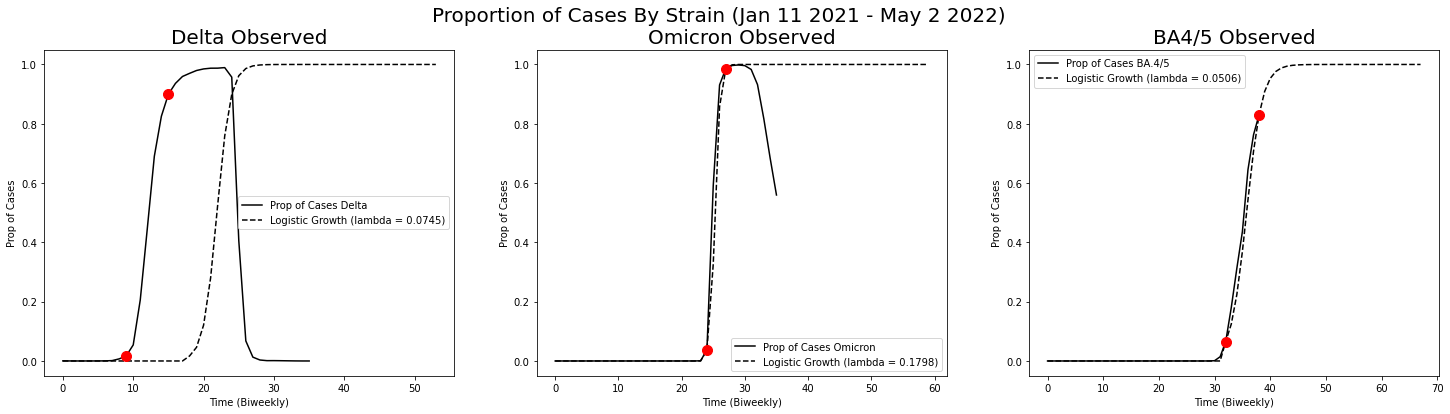

In [25]:
# Corresponding logistic growth curves with estimated b2-b1.
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(25, 6)

ax[0].plot(covid_vc["perc_deltas"], color='black', label='Prop of Cases Delta')
ax[0].plot(betadelta, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.0745)')
# ax[0].plot(betadelta_halfway, color='blue', linestyle = '--', label='Logistic Growth (lambda = 0.0916)')

ax[0].set_xlabel('Time (Biweekly)')
ax[0].set_ylabel('Prop of Cases')
ax[0].set_title("Delta Observed", fontsize='20')
ax[0].plot(9, 0.016874, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
# ax[0].plot(12, 0.4465, marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="blue")
ax[0].plot(15, 0.899, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
ax[0].legend()

ax[1].plot(covid_vc["perc_omicrons"], color='black', label='Prop of Cases Omicron')
ax[1].plot(delta_omicron12, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.1798)')
# ax[1].plot(delta_omicron12_halfway, color='blue', linestyle = '--', label='Logistic Growth (lambda = 0.258)')

ax[1].set_xlabel('Time (Biweekly)')
ax[1].set_ylabel('Prop of Cases') 
ax[1].set_title("Omicron Observed", fontsize='20')
ax[1].plot(24, .0377, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
# ax[1].plot(25, 0.591, marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="blue")
ax[1].plot(27, .986, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
ax[1].legend()

ax[2].plot(new_ba_4_5, color='black', label='Prop of Cases BA.4/5')
ax[2].plot(ba123_ba45, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.0506)')
ax[2].set_xlabel('Time (Biweekly)')
ax[2].set_ylabel('Prop of Cases')
ax[2].set_title("BA4/5 Observed", fontsize='20')
ax[2].plot(32, .0653, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
ax[2].plot(38, .831, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
ax[2].legend()

fig.suptitle("Proportion of Cases By Strain (Jan 11 2021 - May 2 2022)", fontsize='20')

# fig.savefig(r'/Users/JennyH/Documents/math690/figures/variant_competition_logistic.pdf', bbox_inches="tight")
fig.savefig('variant_competition_logistic_updated.pdf')

In [38]:
from matplotlib.pyplot import figure
figure(figsize=(4, 4), dpi=80)

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

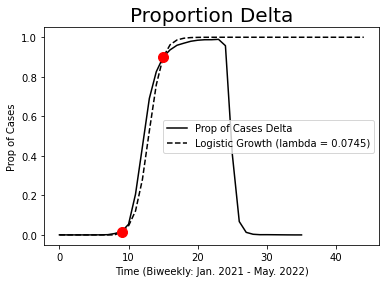

In [39]:
plt.plot(covid_vc["perc_deltas"], color='black', label='Prop of Cases Delta')
plt.plot(betadelta, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.0745)')

plt.xlabel('Time (Biweekly: Jan. 2021 - May. 2022)')
plt.ylabel('Prop of Cases')
plt.title("Proportion Delta", fontsize='20')
plt.plot(9, 0.016874, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
# ax[0].plot(12, 0.4465, marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="blue")
plt.plot(15, 0.899, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.legend()

plt.savefig(r'/Users/JennyH/Documents/math690/figures/logistic_delta.pdf', bbox_inches="tight")

In [59]:
delta_omicron12[20:30]

[0,
 0,
 0,
 0,
 0.037709327,
 0.32691154886270646,
 0.8575434521653023,
 0.9867739894695537,
 0.9989197473464164,
 0.9999127557419176]

In [62]:
list_perc_omicron = list(covid_vc["perc_omicrons"])

In [ ]:
### list_perc_omicron[20:40] 

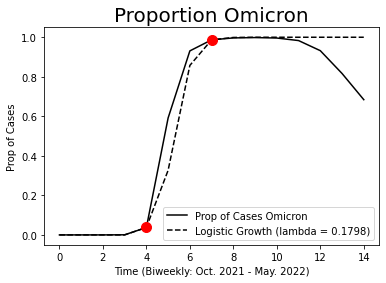

In [78]:
plt.plot(list_perc_omicron[20:35], color='black', label='Prop of Cases Omicron')
plt.plot(delta_omicron12[20:35], color='black', linestyle = '--', label='Logistic Growth (lambda = 0.1798)')
# ax[1].plot(delta_omicron12_halfway, color='blue', linestyle = '--', label='Logistic Growth (lambda = 0.258)')
plt.xlabel('Time (Biweekly: Oct. 2021 - May. 2022)')
plt.ylabel('Prop of Cases') 
plt.title("Proportion Omicron", fontsize='20')
plt.plot(4, .0377, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
# ax[1].plot(25, 0.591, marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="blue")
plt.plot(7, .986, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.legend()

plt.savefig(r'/Users/JennyH/Documents/math690/figures/logistic_omicron.pdf', bbox_inches="tight")

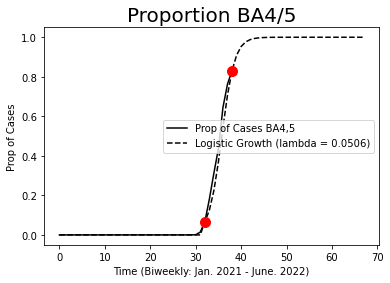

In [31]:
plt.plot(new_ba_4_5, color='black', label='Prop of Cases BA4,5')
plt.plot(ba123_ba45, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.0506)')
plt.xlabel('Time (Biweekly: Jan. 2021 - June. 2022)')
plt.ylabel('Prop of Cases')
plt.title("Proportion BA4/5", fontsize='20')
plt.plot(32, .0653, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
# plt.plot(35, 0.4366, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.plot(38, .831, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.legend()

plt.savefig(r'/Users/JennyH/Documents/math690/figures/logistic_ba45.pdf', bbox_inches="tight")

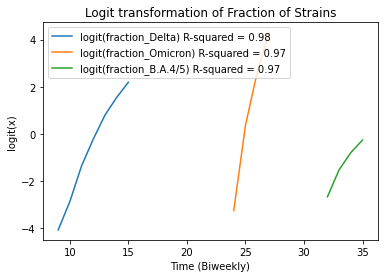

In [78]:
# According to page 4 of var_comp: Can we assume s(t) and r(t) are constant? 
fig, ax = plt.subplots()
ax.plot(covid_vc["logistic_perc_deltas"][9:16], label='logit(fraction_Delta) R-squared = 0.98')
ax.plot(covid_vc["logistic_perc_omicron"][24:28], label='logit(fraction_Omicron) R-squared = 0.97')
ax.plot(covid_vc["logistic_perc_ba45"][32:36], label='logit(fraction_B.A.4/5) R-squared = 0.97')
legend = ax.legend(loc='upper left')
plt.title('Logit transformation of Fraction of Strains')
plt.xlabel('Time (Biweekly)')
plt.ylabel('logit(x)')

fig.savefig(r'/Users/JennyH/Documents/math690/figures/logit_fraction_strains.pdf', bbox_inches="tight")
fig.savefig('logit_fraction_strains.pdf')

# How well does each logistic fit a line?
https://realpython.com/linear-regression-in-python/#simple-linear-regression

In [90]:
# Time units
days = 6*14 # two weeks
steps = 7 # number of data points
x = np.linspace(0, days,steps) # [ 0. 14. 28. 42. 56. 70. 84.]
# print(x)

y = covid_vc["logistic_perc_deltas"][9:16].tolist()
# print(y)

# Turn data into arrays.
x, y = np.array(x), np.array(y)
x = x.reshape(-1,1) # reshape x to be a list of features
# print(x)


# model_delta
model_delta = LinearRegression().fit(x, y)
model_delta

r_sq = model_delta.score(x, y)

print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_delta.intercept_}")
print(f"coefficients: {model_delta.coef_}")

coefficient of determination: 0.9812995686846585
intercept: -3.7508927012888424
coefficients: [0.07590549]


In [91]:
# Time units
days = 3*14 # two weeks
steps = 4 # number of data points
x = np.linspace(0, days,steps) # [ 0. 14. 28. 42. 56. 70. 84.]
# print(x)

y = covid_vc["logistic_perc_omicron"][24:28].tolist()

# Turn data into arrays.
x, y = np.array(x), np.array(y)
x = x.reshape(-1,1) # reshape x
# print(x)

# model_omicron
model_omicron = LinearRegression().fit(x, y)
model_omicron

r_sq = model_omicron.score(x, y)

print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_omicron.intercept_}")
print(f"coefficients: {model_omicron.coef_}")

coefficient of determination: 0.9703745491455967
intercept: -2.726752311834868
coefficients: [0.17792166]


In [92]:
# Time units
days = 3*14 # two weeks
steps = 4 # number of data points
x = np.linspace(0, days,steps) # [ 0. 14. 28. 42. 56. 70. 84.]
# print(x)

y = covid_vc["logistic_perc_ba45"][32:36].tolist()

# Turn data into arrays.
x, y = np.array(x), np.array(y)
x = x.reshape(-1,1) # reshape x
# print(x)

# model_ba45
model_ba45 = LinearRegression().fit(x, y)
model_ba45

r_sq = model_ba45.score(x, y)

print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_ba45.intercept_}")
print(f"coefficients: {model_ba45.coef_}")

coefficient of determination: 0.9705351360889637
intercept: -2.497213953845991
coefficients: [0.05675373]
